In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [47]:
cd ../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [48]:
moving_files = []
for ind, f in enumerate(os.listdir('data/move/')):
    if np.load('data/move/'+f).shape[2] == 100:
        moving_files.append(f)
    else:
        print(np.load('data/move/'+f).shape)
        
sleeping_files = []
for f in os.listdir('data/sleep/'):
    if np.load('data/sleep/'+f).shape[2] == 100:
        sleeping_files.append(f)

In [49]:
len(moving_files), len(sleeping_files)

(2106, 8415)

In [52]:
import random
diff = len(sleeping_files)-len(moving_files)
for i in range(diff):
    ind = random.randint(1,len(moving_files)-1)
    x= moving_files[ind]
    moving_files.append(x)

In [53]:
len(moving_files), len(sleeping_files)

(8415, 8415)

In [72]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if '0413' not in f if '0414' not in f]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if '0414' in f or '0413' in f]
        if mode == 'test':
            self.all_files = [f for f in all_files if 'not including now' in f]
            
        # clean
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
       # labe
       # spec = torch.from_numpy(np.load('data/'self.all_files[idx])).unsqueeze(0)
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0] #check this out
        spec = torch.from_numpy(np.load('data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  spec, label

In [73]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')
test_dataset  = NoahSpectrogramDataset(mode='test')

In [74]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [75]:
len(train_dataset), len(train_loader)

(12536, 392)

In [76]:
len(valid_dataset), len(val_loader)

(4294, 135)

In [78]:
len(test_dataset)

0

In [86]:
train_loader[0]

TypeError: 'DataLoader' object is not subscriptable

## Dumb CNN

In [147]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=61, out_channels=122, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=122, out_channels=244, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(244*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x

## Dropout CNN

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 10

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [149]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
#             if epoch == 0:
#                 bad_data[batch_idx] = data
            
            continue
        
        preds = model(data)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    
    return(epoch_loss)

In [150]:
def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            preds = model(data)
            loss = criterion(preds, labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        return epoch_loss

In [151]:
epochs = []
training_losses = []
val_losses = []
for epoch in range(20):
    avg_train_loss = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 0.4532597064971924
Val loss for epoch 0: 0.6534081101417542
Train loss for epoch 1: 0.2526654303073883
Val loss for epoch 1: 0.8368636965751648
Train loss for epoch 2: 0.16579528152942657
Val loss for epoch 2: 0.8664765954017639
Train loss for epoch 3: 0.12426955252885818


KeyboardInterrupt: 

In [152]:
model.conv1.weight.data.shape

torch.Size([122, 61, 3, 3])

In [160]:
w = model.conv1.weight.data
w_chan0 = w[:,0,:,:]
w_chan1 = w[:,1,:,:]

In [157]:
w_chan0.shape

torch.Size([122, 3, 3])

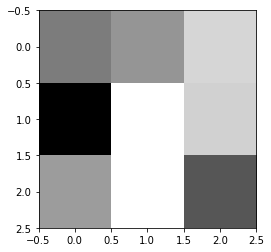

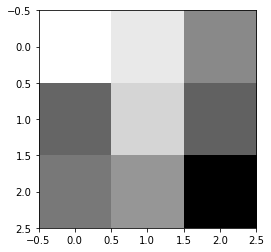

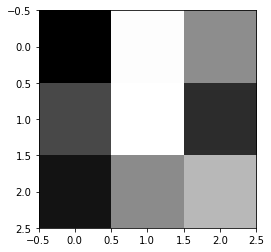

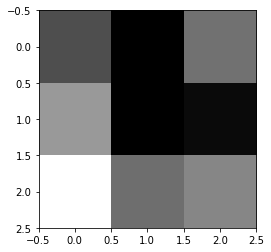

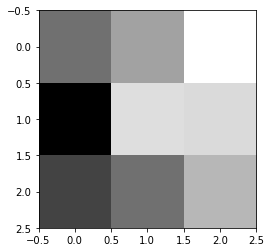

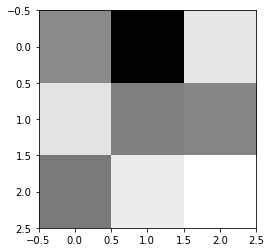

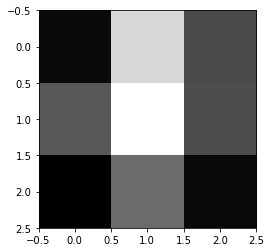

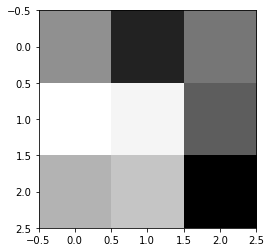

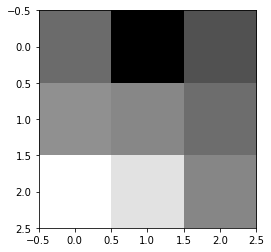

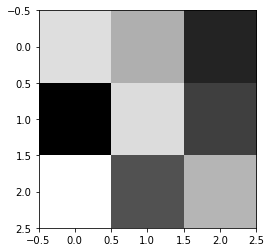

In [159]:
for i in range(10):
    plt.imshow(w_chan0[i], cmap = 'gray')
    plt.show()

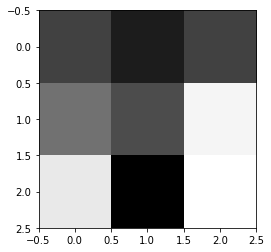

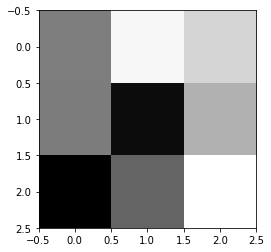

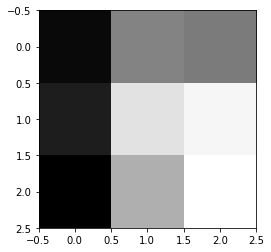

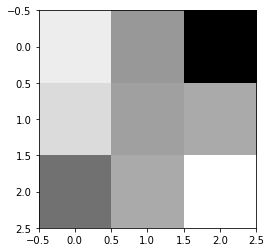

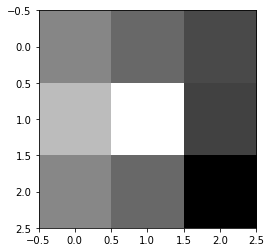

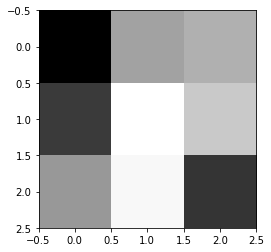

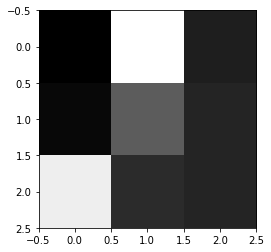

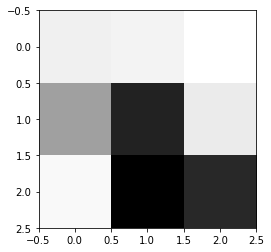

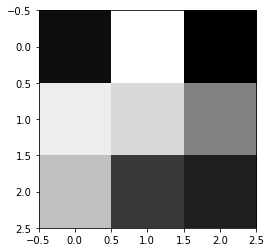

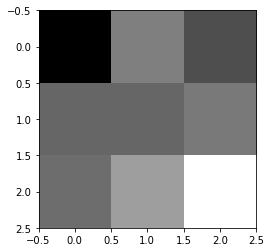

In [161]:
for i in range(10):
    plt.imshow(w_chan1[i], cmap = 'gray')
    plt.show()

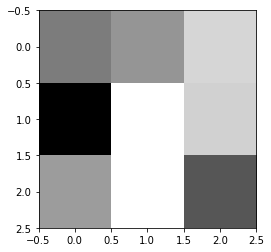

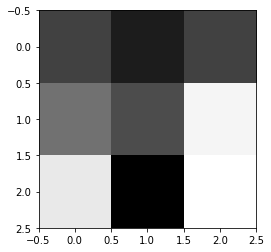

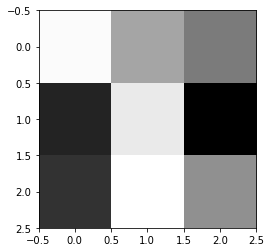

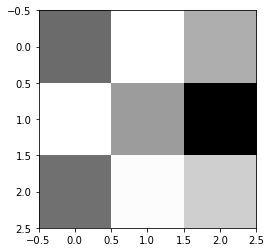

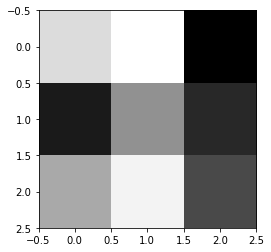

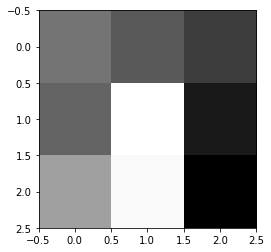

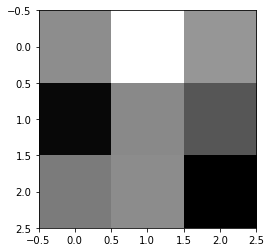

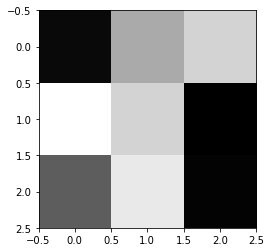

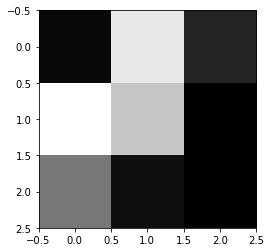

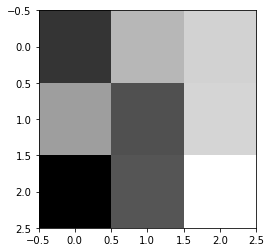

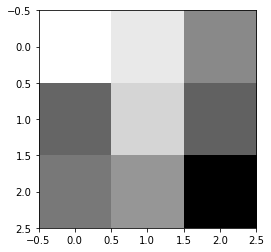

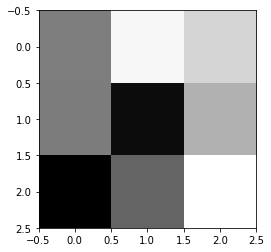

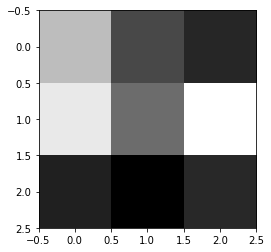

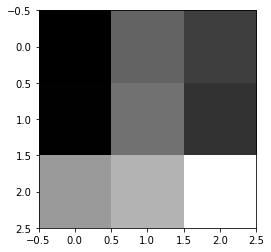

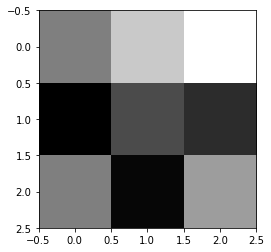

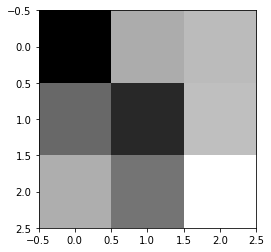

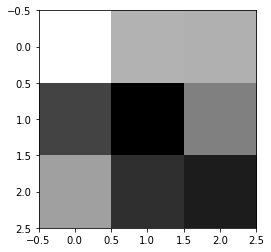

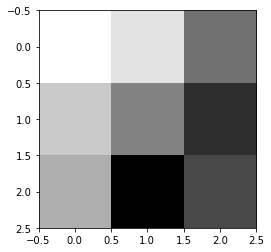

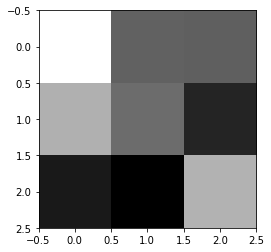

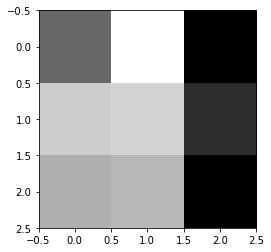

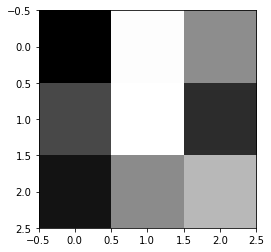

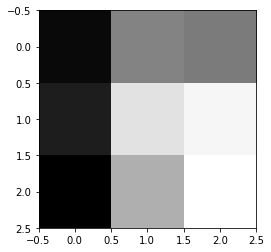

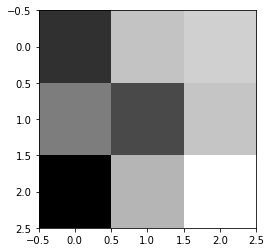

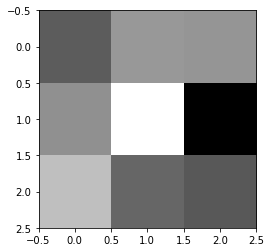

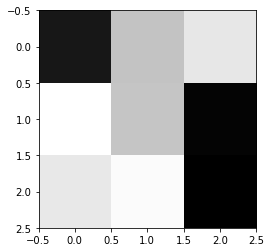

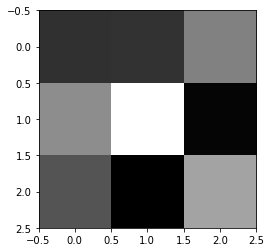

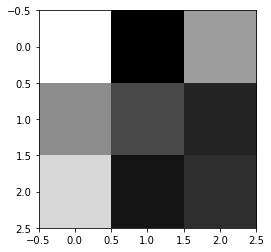

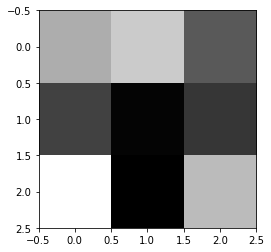

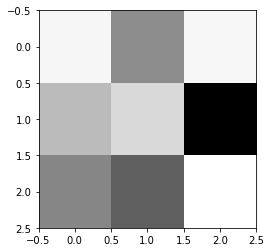

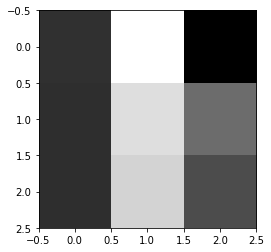

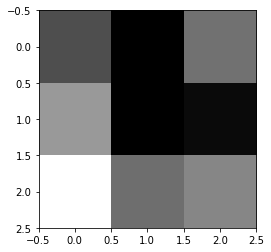

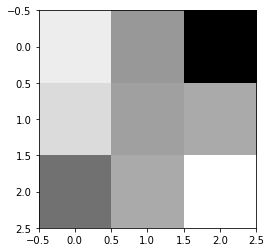

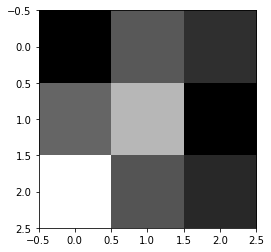

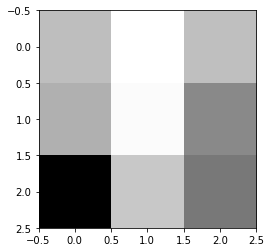

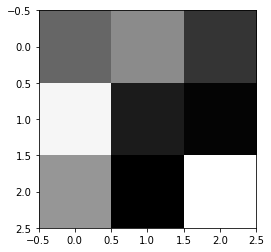

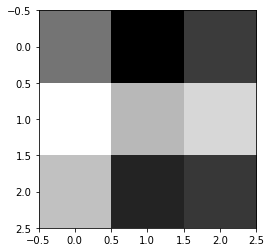

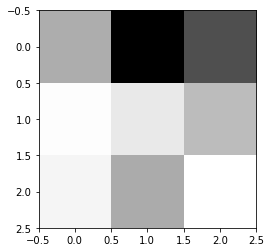

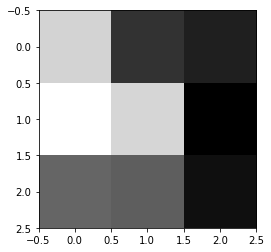

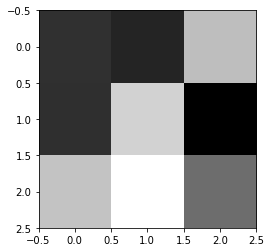

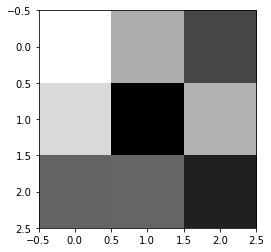

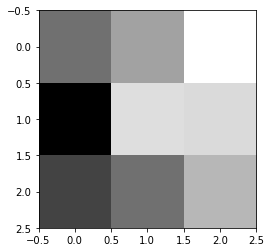

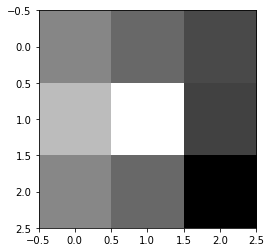

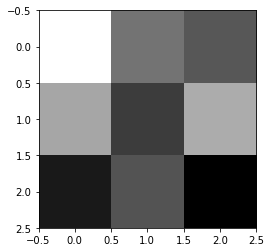

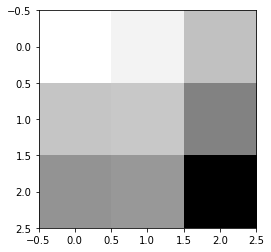

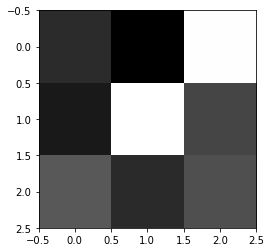

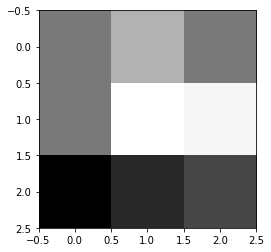

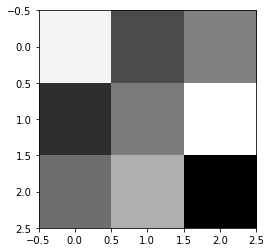

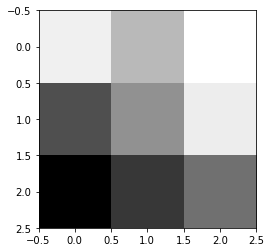

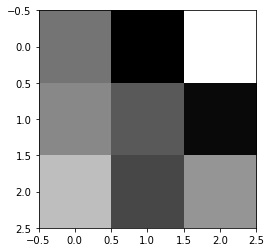

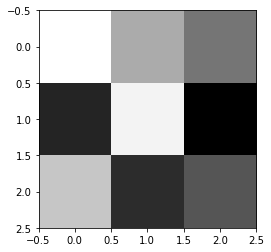

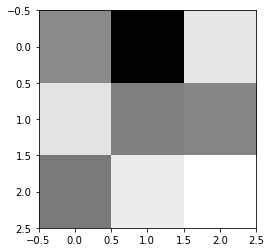

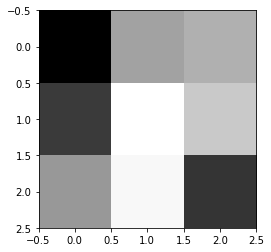

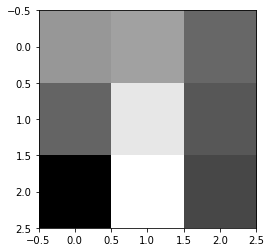

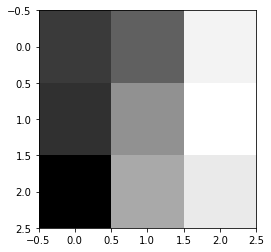

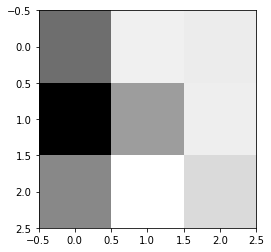

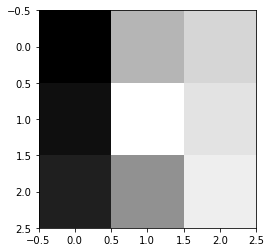

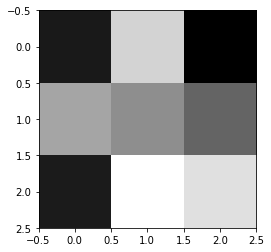

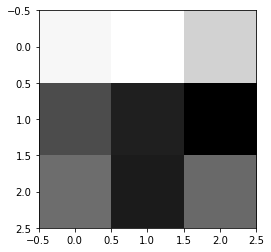

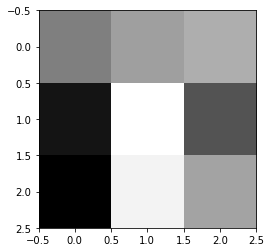

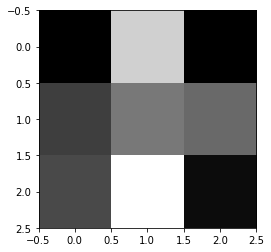

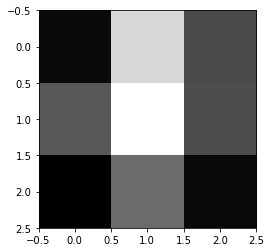

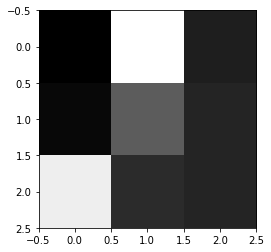

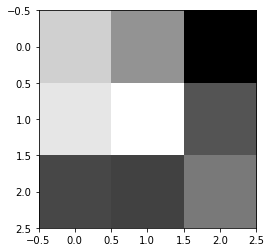

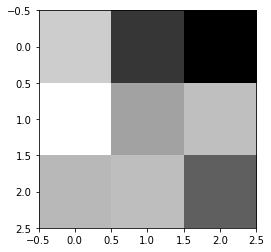

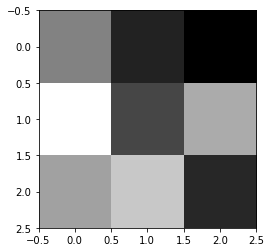

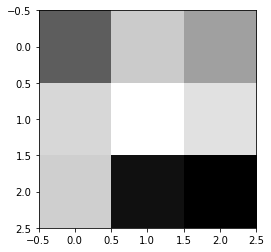

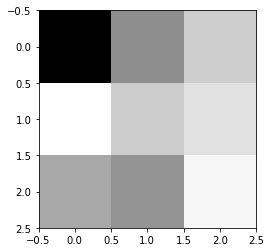

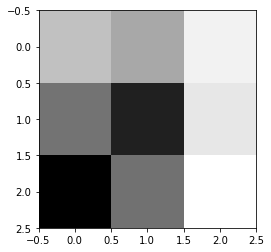

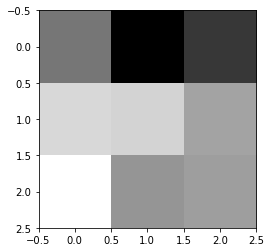

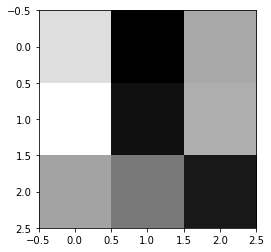

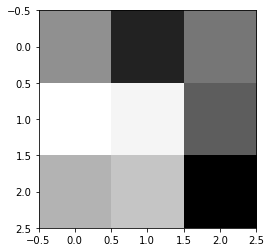

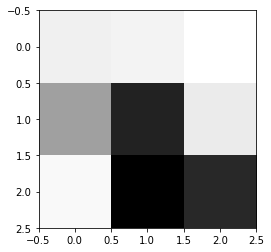

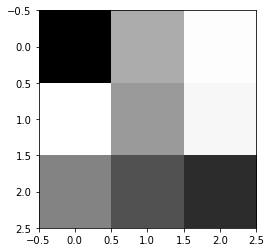

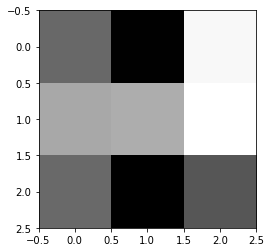

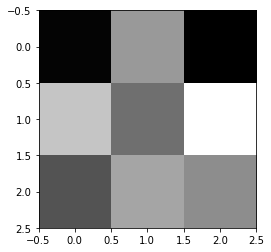

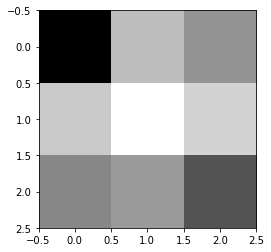

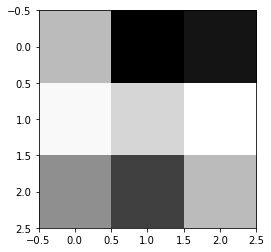

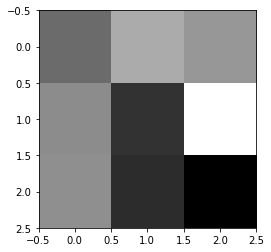

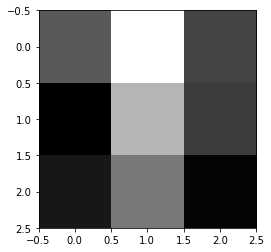

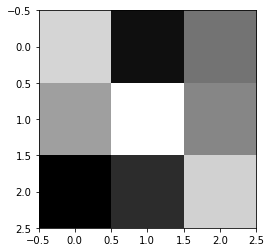

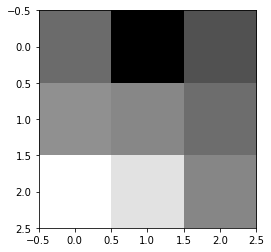

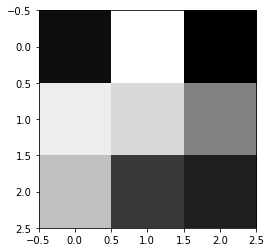

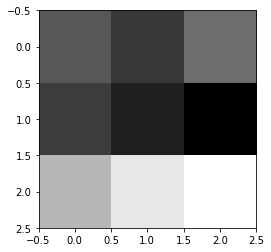

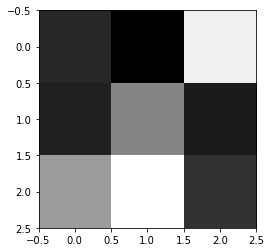

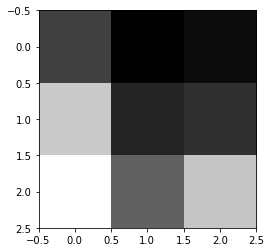

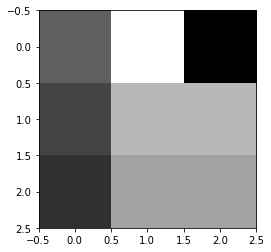

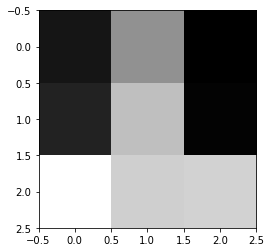

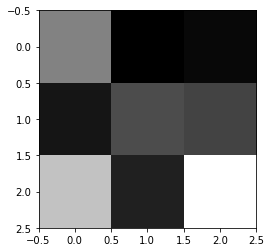

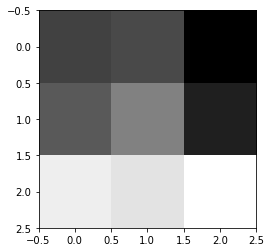

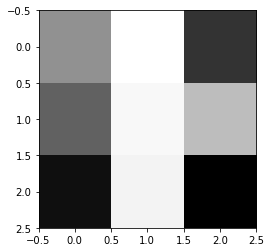

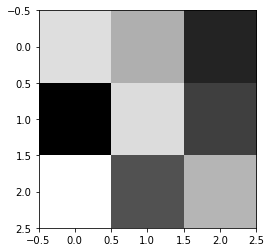

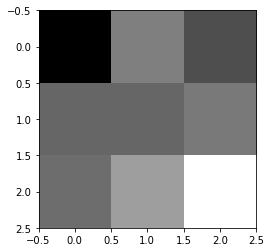

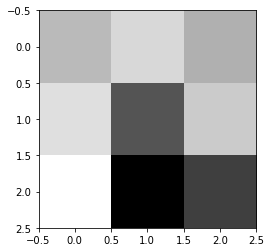

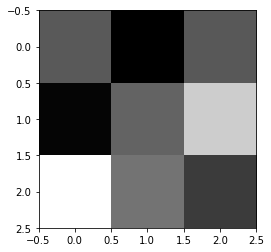

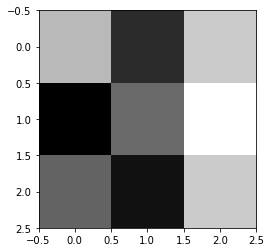

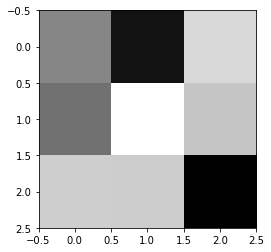

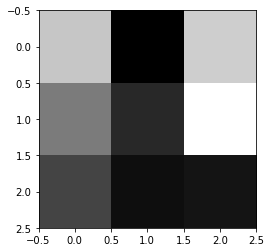

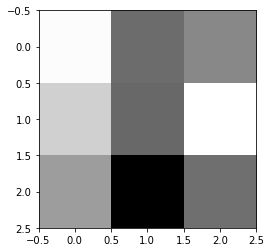

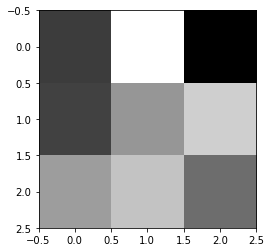

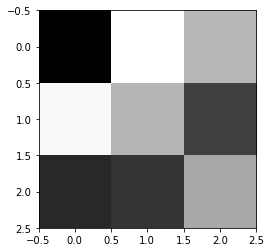

In [154]:
for channel in range(10):
    for c in range(10):
        plt.imshow(model.conv1.weight.data[channel][c], cmap = 'gray')
        plt.show()

In [ ]:
for i in range(len(model.conv1.weight.data)):
#     plt.figure(figsize=(2,2))
    plt.imshow(model.conv1.weight.data[i][0], cmap = 'gray')
    plt.show()

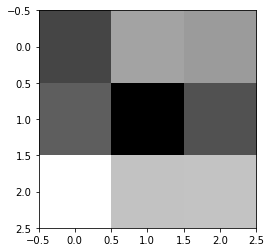

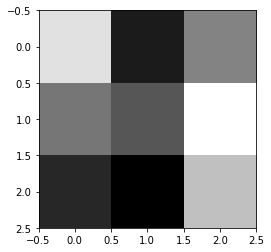

In [33]:
for i in range(len(model.conv1.weight.data)):
#     plt.figure(figsize=(2,2))
    plt.imshow(model.conv1.weight.data[i][0], cmap = 'gray')
    plt.show()

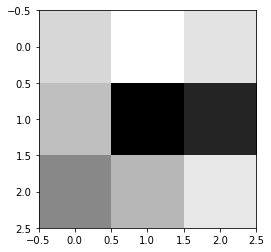

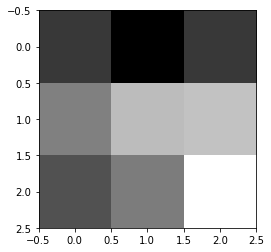

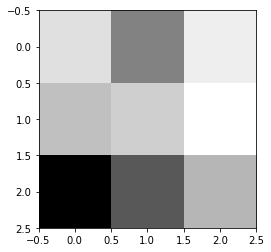

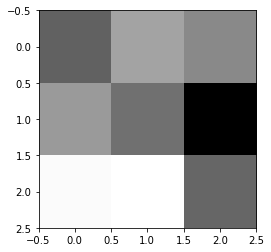

In [21]:
for i in range(len(model.conv2.weight.data)):
#     plt.subplot(1, 2, 1)
    plt.imshow(model.conv2.weight.data[i][0], cmap = 'gray')
    plt.show()

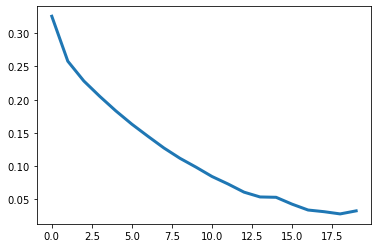

In [34]:
plt.plot(training_losses,linewidth = 3)

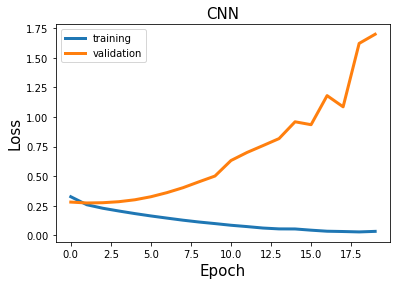

In [35]:
plt.title("CNN", fontsize = 15)
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.plot(training_losses,linewidth = 3,label='training')
plt.plot(val_losses, linewidth = 3,label='validation')
plt.legend()

In [29]:
model(torch.randn(1,1,10,100))

tensor([0.0001], grad_fn=<SigmoidBackward>)

## MLP

In [20]:
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x).flatten()
        x = self.sigmoid(x)
        return x

In [21]:
model = MLP().to(device)

In [22]:
epochs = []
training_losses = []
val_losses = []
for epoch in range(20):
    avg_train_loss = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    val_losses.append(val_loss)

Train loss for epoch 0: 3.7545547485351562
Val loss for epoch 0: 3.4364664554595947
Train loss for epoch 1: 3.4464545249938965
Val loss for epoch 1: 3.4020326137542725
Train loss for epoch 2: 7.147228240966797
Val loss for epoch 2: 6.504098892211914
Train loss for epoch 3: 4.224905490875244
Val loss for epoch 3: 3.650289297103882


KeyboardInterrupt: 